<a href="https://colab.research.google.com/github/dmdiegoar/Quant-code-t0/blob/main/PREDICCI%C3%93N_RBF_GP_GGAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1572704945.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed


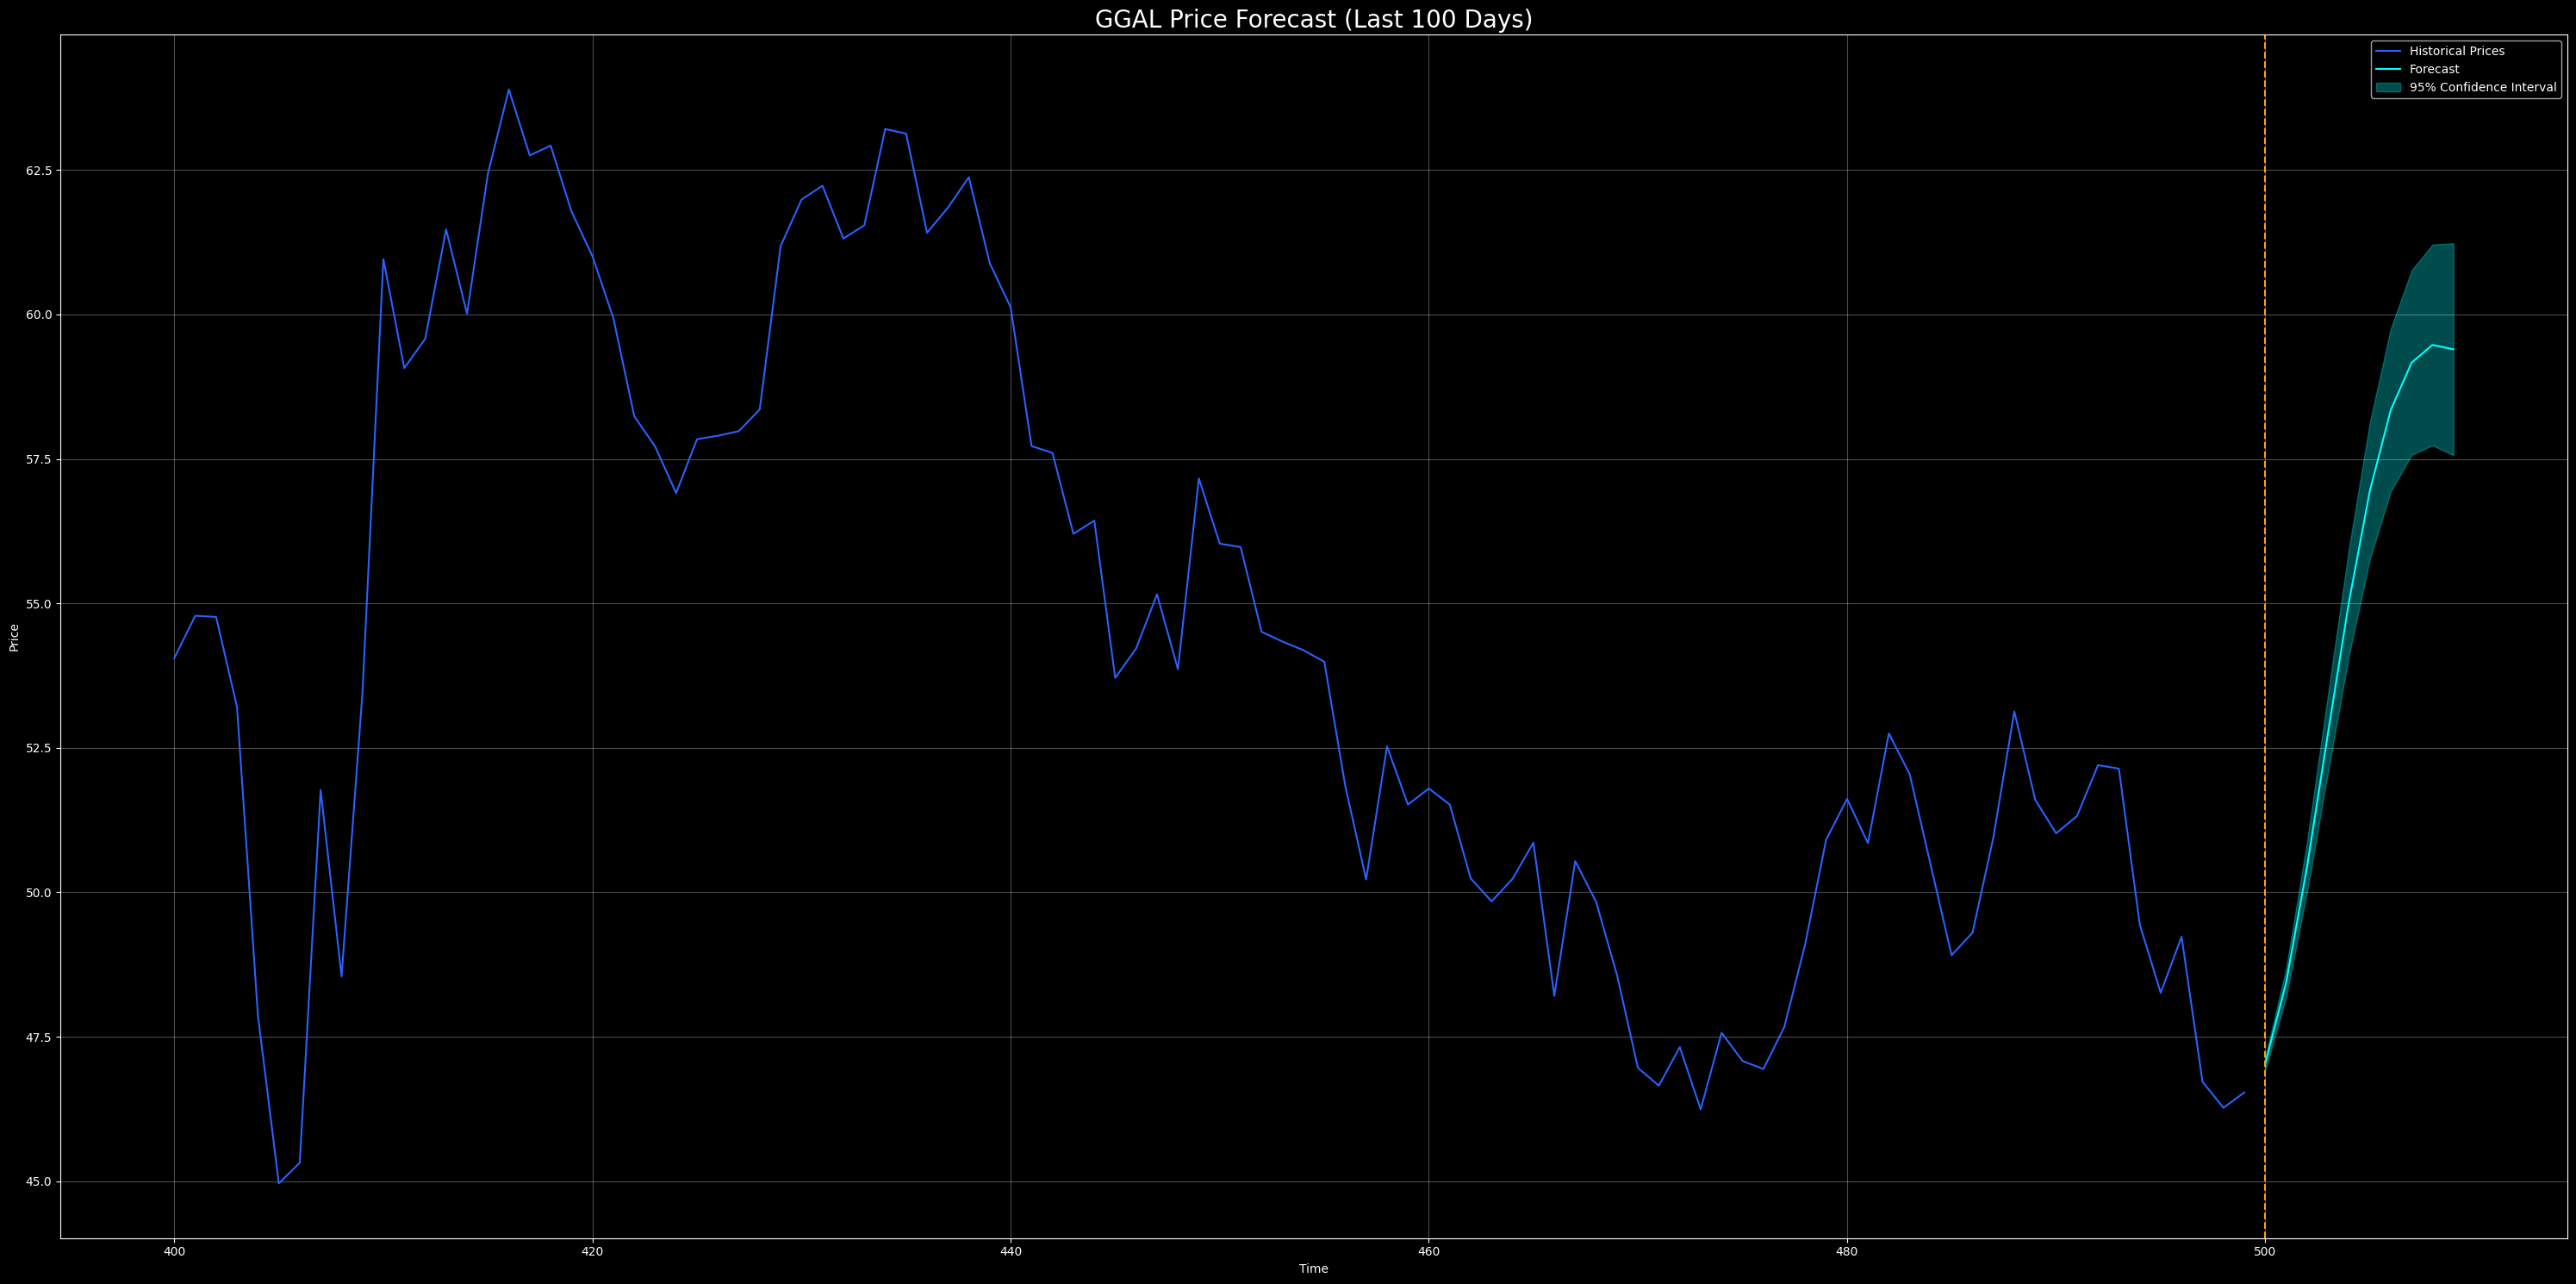

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt


# === Hiperparámetros ===
ticker = 'GGAL'
start_date = '2023-01-01'
end_date = '2025-08-22'
interval = "1d"

window = 200              # Esto toma del Look Back
forecast = 10             # Días a pronosticar
length = 5.0              # Largo del kernel RBF
sigma = 0.025             # Sigma
look_back_period = 500    # Datos totales que usa del DF
zoom_period = 100         # Cuánto mostrar en el gráfico de detalle

# === Funciones ===
def rbf_kernel_matrix(X1, X2, l):
    """Cálculo eficiente de la matriz de kernel RBF usando broadcasting"""
    X1 = X1[:, np.newaxis]
    X2 = X2[np.newaxis, :]
    return np.exp(-np.power(X1 - X2, 2) / (2.0 * l**2))

#Este detalle es importante xq la matriz del kernel compara todos los datos entre si.
#Si lo hacemos en bucles, es medio lento y no tan preciso.
#Con broadcasting de Numpy, se calcula toda la matriz de uina sola vez, sin bucles.

# === Descargar datos ===
data = yf.download(ticker, start=start_date, end=end_date, interval=interval)

if data.empty:
    raise ValueError(f"No se encontraron datos para el ticker {ticker}")

close_prices = data['Close'].values[-look_back_period:]
close_prices = close_prices[~np.isnan(close_prices)]

# === Preparar datos ===
n = len(close_prices)
mean = np.mean(close_prices[-window:])
xtrain = np.arange(window)
xtest = np.arange(window + forecast)
ytrain = close_prices[-window:] - mean  # Centrado

# === Calcular matrices de kernel ===
identity = np.eye(window)
Ktrain = rbf_kernel_matrix(xtrain, xtrain, length) + identity * sigma**2 #AÑADIMOS PEQUEÑA VARIANZSA COMO REGULARIZACIÓN
K_star = rbf_kernel_matrix(xtrain, xtest, length)

# === Predicción ===
K_inv_y = np.linalg.solve(Ktrain, ytrain)
mu = K_star.T @ K_inv_y

# ========================================================
K_test = rbf_kernel_matrix(xtest, xtest, length)
var = K_test - K_star.T @ np.linalg.solve(Ktrain, K_star)
stdv = np.sqrt(np.diag(var))
conf_int = 1.96 * stdv  # 95%

# === Reajustar y extraer pronóstico ===
y_pred = mu + mean
forecast_points = y_pred[-forecast:]
upper_confidence = forecast_points + conf_int[-forecast:]
lower_confidence = forecast_points - conf_int[-forecast:]


plt.style.use('dark_background')

# === GRÁFICO DETALLADO: Últimos 100 + Forecast ===
plt.figure(figsize=(30, 15))
zoom_start = max(0, n - zoom_period)
plt.plot(np.arange(zoom_start, n), close_prices[zoom_start:], label='Historical Prices', color='#2962ff')
plt.plot(np.arange(n, n + forecast), forecast_points, label='Forecast', color='cyan')
plt.fill_between(np.arange(n, n + forecast), lower_confidence, upper_confidence, color='cyan', alpha=0.3, label='95% Confidence Interval')
plt.axvline(x=n, color='orange', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title(f'{ticker} Price Forecast (Last {zoom_period} Days)', fontsize=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()